<a href="https://colab.research.google.com/github/MattLowrieDS/notebooks/blob/master/European_League_Upsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upset percentages in European leagues

In discussing the results of my [last analysis](https://nbviewer.jupyter.org/github/MattLowrieDS/notebooks/blob/master/Promotion_Position.ipynb) with my soccer group, the question of which European league is harder for newly promoted teams came up. This got me thinking about how balanced leagues are overall.

One idea I pursued here, is to use the percentage of upsets as a measure of how balanced any particular league is, with the expectation that leagues with more "upset" results are more balanced than leagues where the expected team always wins. First though I had to determine what constitutes an "upset".

My initial thought was to track how often a lower ranked team in the league table beats a higher ranked team. However this method could be skewed during the first several weeks of league play, in that favored teams with harder initial schedules could be ranked lower in the table.

However, since www.football-data.co.uk provides historical betting data for every match, I decided to use the approach of using betting odds to track whether a team was favored or not for each match.

In [23]:
import pandas as pd

# Import data from football-data.co.uk
data = {'EPL': {}, 'La Liga': {}, 'Bundesliga': {}, 'Serie A': {}, 'Ligue 1': {}}
# Import CSV data from 2018 through 2009
for n in range(18, 8, -1):
  data['EPL']['20{:02d}'.format(n)] = pd.read_csv('https://www.football-data.co.uk/mmz4281/{:02d}{:02d}/E0.csv'.format(n, n+1))
  data['La Liga']['20{:02d}'.format(n)] = pd.read_csv('https://www.football-data.co.uk/mmz4281/{:02d}{:02d}/SP1.csv'.format(n, n+1))
  data['Bundesliga']['20{:02d}'.format(n)] = pd.read_csv('https://www.football-data.co.uk/mmz4281/{:02d}{:02d}/D1.csv'.format(n, n+1))
  data['Serie A']['20{:02d}'.format(n)] = pd.read_csv('https://www.football-data.co.uk/mmz4281/{:02d}{:02d}/I1.csv'.format(n, n+1))
  data['Ligue 1']['20{:02d}'.format(n)] = pd.read_csv('https://www.football-data.co.uk/mmz4281/{:02d}{:02d}/F1.csv'.format(n, n+1))

# Counting backwards ...
start_season = 2018
end_season = 2009

In [13]:
import collections

# Returns the most common prediction with the lowest odds as a letter,
# either home team favored (H), draw (D), or away team favored (A)
def get_odds_consensus(row):
  odds = ''
  # Bet365
  bets = (row['B365H'], row['B365D'], row['B365A'])
  odds += ('H', 'D', 'A')[bets.index(min(bets))]
  # Bet&Win
  bets = (row['BWH'], row['BWD'], row['BWA'])
  odds += ('H', 'D', 'A')[bets.index(min(bets))]
  # Interwetten
  bets = (row['IWH'], row['IWD'], row['IWA'])
  odds += ('H', 'D', 'A')[bets.index(min(bets))]
  # Pinnacle
  # Check if Pinnacle exists first since it is missing from some rows
  if 'PSH' in row:
    bets = (row['PSH'], row['PSD'], row['PSA'])
    odds += ('H', 'D', 'A')[bets.index(min(bets))]
  # William Hill
  bets = (row['WHH'], row['WHD'], row['WHA'])
  odds += ('H', 'D', 'A')[bets.index(min(bets))]
  # VC Bet
  bets = (row['VCH'], row['VCD'], row['VCA'])
  odds += ('H', 'D', 'A')[bets.index(min(bets))]
  return collections.Counter(odds).most_common()[0][0]


In [14]:
# Collect the predicted winner and actual winner of every match
leag = []
year = []
pred = []
actu = []
for league, season_dict in data.items():
  for season, df in season_dict.items():
    for _, row in df.iterrows():
      leag.append(league)
      year.append(season)
      cons = get_odds_consensus(row)
      pred.append(cons)
      actu.append(row['FTR'])

# Predicted/Actual DataFrame
pa_df = pd.DataFrame({
    'League': leag,
    'Season': year,
    'Predicted': pred,
    'Actual': actu,
})

One interesting discovery out of this dataset, is that odds makers never predict a draw, and haven't done so since 2012 in Serie A.

In [15]:
print('Number of matches where a draw was predicted: {}'.format(len(pa_df.loc[pa_df['Predicted'] == 'D',])))
print(pa_df.loc[pa_df['Predicted'] == 'D',])

Number of matches where a draw was predicted: 24
        League Season Predicted Actual
13273  Serie A   2012         D      D
13283  Serie A   2012         D      D
13291  Serie A   2012         D      H
13296  Serie A   2012         D      A
13302  Serie A   2012         D      D
13305  Serie A   2012         D      D
13645  Serie A   2011         D      H
13669  Serie A   2011         D      H
13696  Serie A   2011         D      A
14011  Serie A   2010         D      A
14020  Serie A   2010         D      D
14029  Serie A   2010         D      A
14033  Serie A   2010         D      H
14037  Serie A   2010         D      A
14050  Serie A   2010         D      H
14073  Serie A   2010         D      D
14085  Serie A   2010         D      D
14388  Serie A   2009         D      D
14399  Serie A   2009         D      H
14408  Serie A   2009         D      A
14425  Serie A   2009         D      D
14439  Serie A   2009         D      H
14440  Serie A   2009         D      D
17119  Ligue 1 

In [16]:
from operator import itemgetter

# Create a lookup table of the data we want to chart
lookup = {}
for leag in ['EPL', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1']:
  lookup[leag] = {}
  for year in range(start_season, end_season-1, -1):
    lookup[leag][year] = {}
    for pred in ('Predicted Home Win', 'Predicted Draw', 'Predicted Away Win'):
      lookup[leag][year][pred] = {}
      # Gets the first character after the "Predicted " string, either "H", "D" or "A"
      predicted = pred[len('Predicted ')]
      for actu in 'HDA':
        # Collect the number of matches each season for the predicted outcome/actual outcome pair
        val = len(
            pa_df.loc[
                (pa_df['League'] == leag) &
                (pa_df['Season'] == str(year)) &
                (pa_df['Predicted'] == predicted) &
                (pa_df['Actual'] == actu),])
        lookup[leag][year][pred][actu] = val
      # Now aggregate values for the prediction row
      row_total = sum(lookup[leag][year][pred].values())
      lookup[leag][year][pred]['row total'] = row_total
      if 'Home' in pred:
        favored = lookup[leag][year][pred]['H']
        upset_sum = sum(itemgetter('D', 'A')(lookup[leag][year][pred]))
      elif 'Draw' in pred:
        favored = lookup[leag][year][pred]['D']
        upset_sum = sum(itemgetter('H', 'A')(lookup[leag][year][pred]))
      else:
        favored = lookup[leag][year][pred]['A']
        upset_sum = sum(itemgetter('H', 'D')(lookup[leag][year][pred]))
      lookup[leag][year][pred]['upset total'] = upset_sum
      lookup[leag][year][pred]['favored win pct'] = favored / row_total * 100 if row_total else None
      lookup[leag][year][pred]['upset pct'] = upset_sum / row_total * 100 if row_total else None

In [17]:
from operator import itemgetter

css_cls = {'Predicted Home Win': {'H': 'bkgnd_green', 'D': 'bkgnd_red', 'A': 'bkgnd_red'},
           'Predicted Draw': {'H': 'bkgnd_red', 'D': 'bkgnd_green', 'A': 'bkgnd_red'},
           'Predicted Away Win': {'H': 'bkgnd_red', 'D': 'bkgnd_red', 'A': 'bkgnd_green'}}

# Create an HTML table to display the raw data
html = '<table>'
for leag in lookup.keys():
  for year in lookup[leag].keys():
    html += ('<thead><th>{} {}</th>'.format(leag, year) +
             '<th>Actual Home Win</th>' +
             '<th>Actual Draw</th>' +
             '<th>Actual Away Win</th>' +
             '<th>Upsets</th>' +
             '<th>Favored Won Pct</th>' +
             '<th>Upset Pct</th>' +
             '</thead><tbody>')
    for pred in lookup[leag][year].keys():
      # Many seasons do not have predictions for draws, so ignore adding the row to the table
      if lookup[leag][year][pred]['row total']:
        html += '<tr><td>' + pred + '</td>'
        for actu in 'HDA':
          val = lookup[leag][year][pred][actu]
          html += ('<td class="{}">{}</td>'.format(css_cls[pred][actu], val))
        html += '<td>{}</td>'.format(lookup[leag][year][pred]['upset total'])
        html += '<td>{:.2f}%</td>'.format(lookup[leag][year][pred]['favored win pct'])
        html += '<td>{:.2f}%</td>'.format(lookup[leag][year][pred]['upset pct'])
        html += '</tr>'
html += '</table>'


In [18]:
from IPython.display import display, HTML

style = """
<style> 
html {
  font-family: sans-serif;
}
table {
  border-collapse: collapse;
  border: 1px solid black;
}
td, th {
  border: 1px solid rgb(190,190,190);
  padding: 10px 20px;
  text-align: left;
}
th {
  background-color: rgb(196, 219, 239);
}
td.bkgnd_green {
  background-color: #d9ead3;
}
td.bkgnd_red {
  background-color: #f4cccc;
}
</style>
"""
display(HTML(style + html))

In [19]:
# Create a data frame for the chart
league = []
season = []
pct_upsets = []
tooltips = []
for leag in ['EPL', 'La Liga', 'Serie A', 'Bundesliga', 'Ligue 1']:
  for year in range(start_season, end_season-1, -1):
    league.append(leag)
    season.append(str(year))
    phw = lookup[leag][year]['Predicted Home Win']
    pdw = lookup[leag][year]['Predicted Draw']
    paw = lookup[leag][year]['Predicted Away Win']
    upsets = phw['D'] + phw['A'] + pdw['H'] + pdw['A'] + paw['H'] + paw['D']
    total_matches = phw['H'] + phw['D'] + phw['A'] + paw['H'] + paw['D'] + paw['A']
    pct_upsets.append(upsets/total_matches)
    tooltips.append('{:.1f}%'.format(upsets/total_matches*100))

chart_df = pd.DataFrame({
    'League': league,
    'Season': season,
    'Pct Upsets': pct_upsets,
    'thresh': [0.5] * len(league),
    'tooltips': tooltips,
})


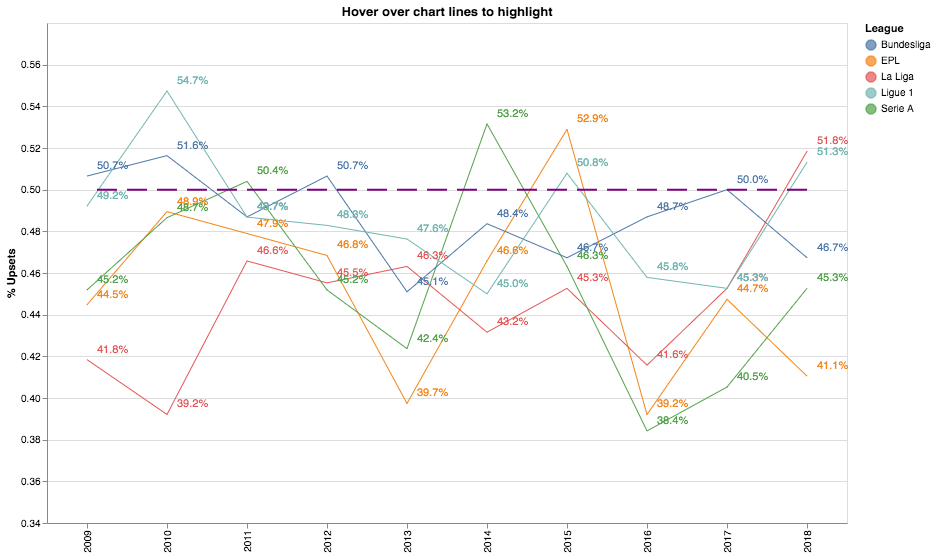

In [20]:
import altair as alt

# Use this renderer in Jupyter Notebook
#alt.renderers.enable('notebook')
# Use this renderer in Jupyter Lab
alt.renderers.enable('default')

mouse_hover = alt.selection(type='single',
                            on='mouseover',
                            nearest=True,
                            fields=['League'])

base = (
    alt.Chart(chart_df)
        .properties(width=800,
                    height=500,
                    title='Hover over chart lines to highlight')
        .encode(x=alt.X(shorthand='Season:O',
                        title=''),
                y=alt.Y(shorthand='Pct Upsets:Q',
                        scale=alt.Scale(domain=[0.35, 0.55]),
                        title='% Upsets'),
                color='League')    
)

points = (
    base
        .mark_circle()
        .encode(opacity=alt.value(0))
        .add_selection(mouse_hover)
)

lines = (
    base
        .mark_line()
        .encode(size=alt.condition(~mouse_hover,
                                   alt.value(1),
                                   alt.value(4)))
)

tooltips = (
    base
        .mark_text(align='left',
                   dx=10,
                   dy=-10)
        .encode(text=alt.condition(mouse_hover,
                                   'tooltips:N',
                                   alt.value('')))
)

rule = (
    base
        .mark_line(strokeDash=(20, 10))
        .encode(x='Season:O',
                y='thresh:Q',
                color=alt.value('purple'))
)

points + lines + tooltips + rule

As shown in the chart above, upset percentages vary across leagues each season. It is interesting to note that upset percentages are greater than 50% at least once in every league. Bundesliga and Ligue 1 each contain 3 seasons with an upset percentage over 50%. EPL (Leicester City's title season of course!) and La Liga each have one season over 50% Not sure if this is more an indicator of league balance or an indicator of how poor the odds makers are.

Below is a chart of the aggregated average of upsets for each league over the last 10 seasons. Bundesliga and Ligue 1 have the highest average percentage of upsets, suggesting that there is more balance across teams. EPL and La Liga have the lowest upset percentage suggesting that these leagues are more dominated by the teams expected to win.

In [21]:
avg_df = pd.DataFrame({
  'League': ['EPL', 'La Liga', 'Bundesliga', 'Serie A', 'Ligue 1'],
  'Upset Avg 2009-2018': [
    chart_df.loc[(chart_df['League'] == 'EPL'), 'Pct Upsets'].aggregate('average'),
    chart_df.loc[(chart_df['League'] == 'La Liga'), 'Pct Upsets'].aggregate('average'),
    chart_df.loc[(chart_df['League'] == 'Bundesliga'), 'Pct Upsets'].aggregate('average'),
    chart_df.loc[(chart_df['League'] == 'Serie A'), 'Pct Upsets'].aggregate('average'),
    chart_df.loc[(chart_df['League'] == 'Ligue 1'), 'Pct Upsets'].aggregate('average'),
  ]
})

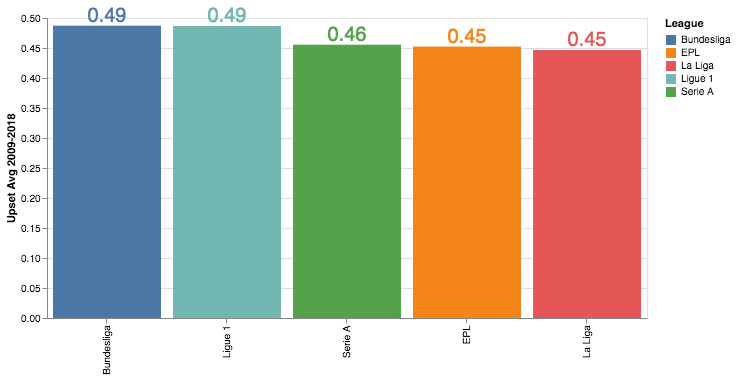

In [22]:
avg_chart = (
    alt.Chart(avg_df)
        .properties(width=600)
        .mark_bar()
        .encode(x=alt.X(shorthand='League:O',
                        title='',
                        sort=alt.EncodingSortField(field='Upset Avg 2009-2018',
                                                   order='descending')),
                y='Upset Avg 2009-2018:Q',
                color='League:N')
)

labels = (
    avg_chart
        .mark_text(dy=-10,
                   size=20)
        .encode(text=alt.Text(shorthand='Upset Avg 2009-2018:Q',
                              format='.2f'))
)

avg_chart + labels